In [1]:
import torch

from botorch.utils.multi_objective import is_non_dominated

from ellipse_utils import (
    sample_2d_circle,
    ellipsify,
    get_ellipse_patch,
)

from scalarize.utils.scalarization_functions import LinearScalarization

import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams[
    "text.latex.preamble"
] = r"\usepackage{amsmath}\usepackage{amssymb}\usepackage{color}"

In [2]:
tkwargs = {"dtype": torch.double, "device": "cpu"}
seed = 1
torch.manual_seed(seed)
num_samples = 1000
base_samples = sample_2d_circle(n=num_samples, **tkwargs)

num_surface_samples = 2**10
t = torch.linspace(0, 1, num_surface_samples, **tkwargs)
surface_samples = torch.column_stack(
    [torch.cos(2 * torch.pi * t), torch.sin(2 * torch.pi * t)]
)

In [3]:
# Define the ellipses.
radii = torch.tensor(
    [
        [0.2, 0.1],
        [0.1, 0.05],
        [0.075, 0.1],
        [0.2, 0.05],
        [0.15, 0.1],
    ],
    **tkwargs
)

angles = torch.tensor(
    [
        -0.2 * torch.pi,
        -0.05 * torch.pi,
        0.05 * torch.pi,
        0.0 * torch.pi,
        0.1 * torch.pi,
    ],
    **tkwargs
)

translates = torch.tensor(
    [
        [0.3, 0.8],
        [0.45, 0.5],
        [0.70, 0.8],
        [0.77, 0.35],
        [0.8, 0.15],
    ],
    **tkwargs
)

samples = []
for i in range(len(radii)):
    samples.append(
        ellipsify(
            base_samples, radius=radii[i], angle=angles[i], translate=translates[i]
        )
    )

# Get the Pareto fronts.
ell_samples = []
for i in range(len(radii)):
    ell_samples.append(
        ellipsify(
            surface_samples, radius=radii[i], angle=angles[i], translate=translates[i]
        )
    )

p_samples = []
for i, sample in enumerate(ell_samples):
    p_sample = sample[is_non_dominated(sample)]
    p_sample = p_sample[p_sample[:, 0].argsort()]
    p_samples.append(p_sample)

inv_p_samples = []
for i, sample in enumerate(ell_samples):
    inv_p_sample = sample[is_non_dominated(-sample)]
    inv_p_sample = inv_p_sample[inv_p_sample[:, 0].argsort()]
    inv_p_samples.append(inv_p_sample)

nadir = torch.zeros(1, 2, **tkwargs)

# Scalarized problems.
weights = torch.tensor([[0.85, 0.15]], **tkwargs)
scalarization_fn = LinearScalarization(weights=weights)
grid_length = 128
num_points = grid_length * grid_length

g1 = torch.linspace(-0.1, 1.1, grid_length).to(**tkwargs)
g2 = torch.linspace(-0.1, 1.1, grid_length).to(**tkwargs)
X, Y = torch.meshgrid(g1, g2, indexing="xy")

Z = torch.column_stack(
    [X.reshape(grid_length * grid_length), Y.reshape(grid_length * grid_length)]
)
Z = scalarization_fn(Z).reshape(grid_length, grid_length)

# Upper set scalarized problem.
up_best_val = -100
up_best_index = -1
up_vectors = []

for i in range(len(radii)):
    vec = ell_samples[i][scalarization_fn(ell_samples[i]).argmin()]
    s_value = scalarization_fn(vec)
    if s_value > up_best_val:
        up_best_val = max(s_value[0], up_best_val)
        up_best_index = i
    up_vectors.append(vec)

# Lower set scalarized problem.
low_best_val = -100
low_best_index = -1
low_vectors = []
for i in range(len(radii)):
    vec = ell_samples[i][scalarization_fn(ell_samples[i]).argmax()]
    s_value = scalarization_fn(vec)
    if s_value > low_best_val:
        low_best_val = max([s_value[0], low_best_val])
        low_best_index = i
    low_vectors.append(vec)

# Best contours.
w = weights.squeeze(0)
x = torch.linspace(-10, 10, 101, **tkwargs)
up_y = (-w[0] * x + up_best_val) / w[1]
low_y = (-w[0] * x + low_best_val) / w[1]

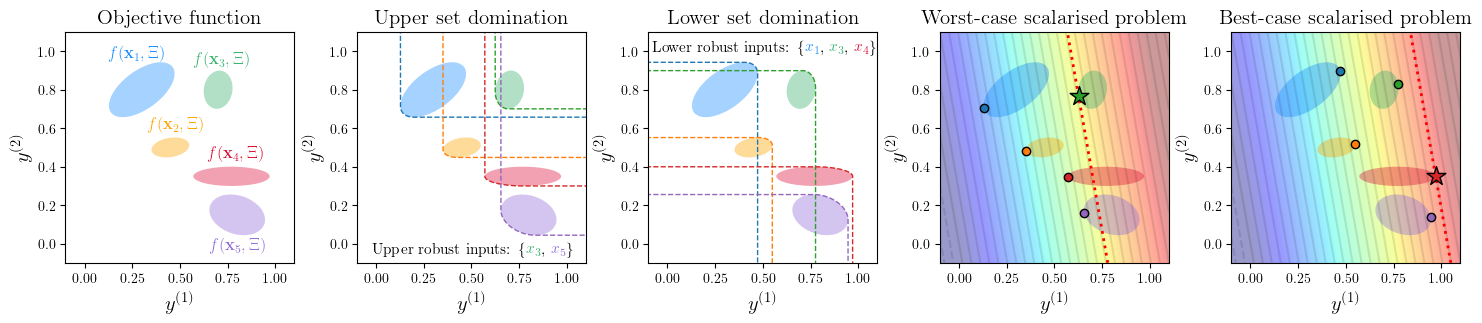

In [4]:
fig = plt.figure(figsize=(18, 3))
gs = gridspec.GridSpec(2, 10)
gs.update(wspace=0.75, hspace=1.0)

ax1 = fig.add_subplot(gs[0:2, 0:2])
ax2 = fig.add_subplot(gs[0:2, 2:4])
ax3 = fig.add_subplot(gs[0:2, 4:6])
ax4 = fig.add_subplot(gs[0:2, 6:8])
ax5 = fig.add_subplot(gs[0:2, 8:10])

axes = [ax1, ax2, ax3, ax4, ax5]

colors = ["dodgerblue", "orange", "mediumseagreen", "crimson", "mediumpurple"]

for ax in axes:
    for i in range(len(radii)):
        ellipse, transform = get_ellipse_patch(
            radius=radii[i],
            angle=angles[i],
            translate=translates[i],
            alpha=0.4,
            facecolor=colors[i],
        )
        ellipse.set_transform(transform + ax.transData)
        ax.add_patch(ellipse)
##############################################################################
# Main.
ax = ax1
delta = torch.tensor(
    [
        [-0.175, 0.17],
        [-0.12, 0.1],
        [-0.13, 0.14],
        [-0.13, 0.10],
        [-0.15, -0.18],
    ],
    **tkwargs,
)
for i, t in enumerate(translates):
    d = delta[i]
    ax.annotate(
        rf"$f(\mathbf{{x}}_{i+1}, \Xi)$",
        (t[0] + d[0], t[1] + d[1]),
        fontsize=12,
        color=colors[i],
    )
ax.set_title("Objective function", fontsize=15)
##############################################################################
# Upper set domination.
ax = ax2
max_value = 2
for i in range(len(radii)):
    sample = inv_p_samples[i]
    domination_contour = [
        torch.tensor([sample[0, 0], max_value], **tkwargs),
        sample,
        torch.tensor([max_value, sample[-1, 1]], **tkwargs),
    ]
    domination_contour = torch.row_stack(domination_contour)
    ax.plot(
        domination_contour[:, 0],
        domination_contour[:, 1],
        alpha=1,
        linestyle="--",
        linewidth=1,
    )
ax.set_title("Upper set domination", fontsize=15)
ax.annotate(
    r"Upper robust inputs: $\{$\quad, \quad$\}$", (-0.02, -0.05), fontsize=11, color="k"
)
ax.annotate(r"$x_3$", (0.786, -0.05), fontsize=11, color=colors[2])
ax.annotate(r"$x_5$", (0.916, -0.05), fontsize=11, color=colors[4])
##############################################################################
# Lower set domination.
ax = ax3
min_value = -1
for i in range(len(radii)):
    sample = p_samples[i]
    domination_contour = [
        torch.tensor([min_value, sample[0, 1]], **tkwargs),
        sample,
        torch.tensor([sample[-1, 0], min_value], **tkwargs),
    ]
    domination_contour = torch.row_stack(domination_contour)
    ax.plot(
        domination_contour[:, 0],
        domination_contour[:, 1],
        alpha=1,
        linestyle="--",
        linewidth=1,
    )

ax.set_title("Lower set domination", fontsize=15)
ax.annotate(
    r"Lower robust inputs: $\{$\quad, \quad, \quad$\}$",
    (-0.08, 1.0),
    fontsize=11,
    color="k",
)
ax.annotate(r"$x_1$", (0.72, 1.0), fontsize=11, color=colors[0])
ax.annotate(r"$x_3$", (0.845, 1.0), fontsize=11, color=colors[2])
ax.annotate(r"$x_4$", (0.975, 1.0), fontsize=11, color=colors[3])
##############################################################################
# Scalarized problems.
for ax in [ax4, ax5]:
    ax.contour(X, Y, Z, colors="black", alpha=0.1, levels=30)
    img = ax.imshow(
        Z,
        extent=[-0.1, 1.1, -0.1, 1.1],
        origin="lower",
        cmap="jet",
        alpha=0.4,
        vmin=0.0,
        vmax=1.0,
        aspect="auto",
    )
##############################################################################
# Upper scalarized problems.
ax = ax4
for i in range(len(radii)):
    vec = up_vectors[i]
    if i != up_best_index:
        ax.scatter(vec[0], vec[1], marker="o", edgecolors="k")
    else:
        ax.scatter(vec[0], vec[1], marker="*", edgecolors="k", s=200, zorder=5)

ax.plot(x, up_y, linestyle=":", color="r", zorder=4, linewidth=2)
ax.set_title("Worst-case scalarised problem", fontsize=15)
##############################################################################
# Lower scalarized problems.
ax = ax5
for i in range(len(radii)):
    vec = low_vectors[i]
    if i != low_best_index:
        ax.scatter(vec[0], vec[1], marker="o", edgecolors="k")
    else:
        ax.scatter(vec[0], vec[1], marker="*", edgecolors="k", s=200, zorder=5)

ax.plot(x, low_y, linestyle=":", color="r", zorder=4, linewidth=2)
ax.set_title("Best-case scalarised problem", fontsize=15)

for ax in axes:
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel(r"$y^{(1)}$", fontsize=15)
    ax.set_ylabel(r"$y^{(2)}$", fontsize=15)

plt.show()